This notebook shows several classes and methods of `ELENA`, making it explicit how to compute the GW spectrum from a Lagrangian input. It showcases the full chain of computation, including:
- defining the model parameters;
- find the critical temperatures;
- compute the action and other relevant quantities over the full range of temperatures;
- compute the thermal parameters entering the GW spectrum computation;
- compute the final GW spectrum.

# Add paths to let Python find the necessary source code

In [147]:
import sys
import os
from pathlib import Path
import numpy as np
import time

# Get the directory of the current script
script_dir = Path(os.getcwd()).resolve()

# Add the src directory to the Python path
sys.path.append(str(Path(script_dir / '../src').resolve()))

figure_dir = '../data/processed/plots/manual/'
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

In [148]:
def g_roll(lambda_):
    return ( ((16 * np.pi**2 * lambda_)/3) * (1 - lambda_ * (5 + 2*np.log(2) )/(8 * np.pi**2) ) )**(1/4)

# Construct the scalar potential
The present example uses the minimal dark photon plus dark Higgs model presented in (arXiv:2501.15649 [hep-ph]). Different models can be implemented following the procedure outlined in CosmoTransitions.

In the cell below:
- `lambda_` is the quartic dark-Higgs self-coupling;
- `g` is the dark-photon gauge coupling constant;
- `vev` is the vacuum-expectation-value of the dark-Higgs field at zero temperature;
- `units` is the energy scale in which dimensionful quantities are computed. It must be a string with possible values `"MeV"`, `"GeV"` or `"TeV"`. If not specified, GeV is assumed;
- `description` is a string that can be used to give a human-readable description of the parameter point, useful to recall results later.

This potential assumes the on-shell renormalisation method, thus the quantities defined above are the observable physical ones.

`ELENA` uses `CosmoTransitions` (Comput. Phys. Commun. 183 (2012), 2006-2013 [arXiv:1109.4189 [hep-ph]]) to build the finite-temperature potential. If you use this functionality of please cite it.

In [149]:
import numpy as np
from utils import convert_units
from model import model

units = np.random.choice(list(convert_units.keys())) # This chooses a random energy scale among [MeV, GeV, TeV]

# This selects a pair of couplings for which we expect a first-order phase transition over large intervals of vevs
lambda_ = 1.5e-3
g = 0.5
#vev = np.random.uniform(0, 1e3) # This chooses a random vev between [0, 1e3] in the selected units
vev, units = 500, "MeV"
description = "Fast"

# Alternatively, these are the bechmark points presented in arXiv:2501.15649 [hep-ph]
lambda_, g, vev, units, description  = 6e-3, 0.75002, 500, "MeV", "Slow" # BP1
# lambda_, g, vev, units, description  = 6e-3, 0.74982, 1000, "MeV", "BP2"
# lambda_, g, vev, units, description  = 6e-3, 0.74972, 3, "GeV", "BP3" 
# lambda_, g, vev, units, description  = 1e-2, 0.85412, 1, "GeV", "BP4"

# lambda_, g, vev, units, description =  0.05470235737745018, 1.355135688825716, 20.36109221456702, "MeV", "MCMC_MLE"
# lambda_, g, vev, units, description =  1.4446298648795583e-02, 7.7773105066007098e-01, 4.1207828488542368e+01, "MeV", "MCMC_MAP"
# lambda_, g, vev, units, description =  1.2140067768469315e-02, 8.9868817482047314e-01, 4.7463166425026273e+01, "MeV", "MCMC_bayes"

# description = f"vev = {vev} {units}"

# This constructs the finite-temperature potential as an instance of the class model. 
dp = model(vev, lambda_, g, xstep= vev * 1e-3, Tstep=vev * 1e-3)
V = dp.DVtot # This is the scalar potential shifted such that the false vacuum is located at ϕ = 0 for each value of the temperature
dV = dp.gradV # This is the gradient of the scalar potential

print(f"lambda = {lambda_}")
print(f"g = {g}")
print(f"vev = {vev} {units}")

lambda = 0.006
g = 0.75002
vev = 500 MeV


## Plot the potential and gradient at some random temperature and at T = 0

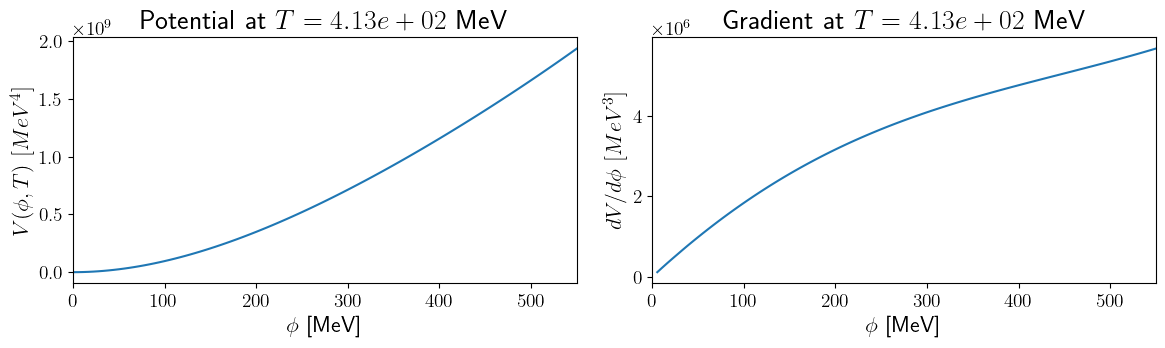

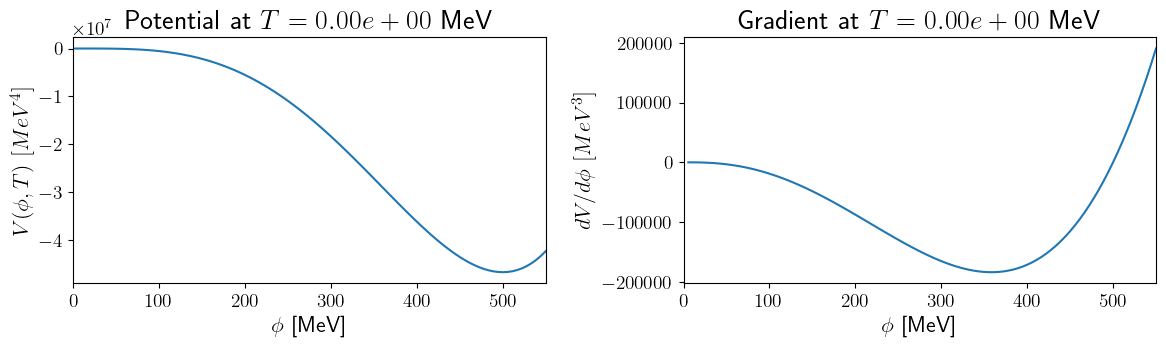

In [150]:
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

# Set global font size parameters
plt.rcParams.update({
    'font.size': 18,              # Base font size
    'axes.titlesize': 20,         # Title font size
    'axes.labelsize': 16,         # Label font size
    #'axes.labelweight': 'bold',   # Make axis labels bold
    'xtick.labelsize': 14,        # X-tick label size
    'ytick.labelsize': 14,        # Y-tick label size
    'legend.fontsize': 14,        # Legend font size
    'figure.titlesize': 20,        # Figure title size
    'text.usetex': True,          # Use LaTeX for all text rendering
    'text.latex.preamble': r'\usepackage{amsmath,amssymb,bm}'
})

T = np.random.uniform(0, vev)

phi = np.linspace(0, 1.1 * vev, 100)
phi = phi.reshape(-1,1)

for t in [T, 0]:
    v = V(phi, t)
    dv = dV(phi, t)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(phi, v)
    axes[0].set_title(f"Potential at $T = {t:.2e}$ {units}")
    axes[0].set_xlabel(fr"$\phi$ [{units}]")
    axes[0].set_ylabel(f"$V(\phi, T)$ $[{units}^{4}]$")

    axes[1].plot(phi[1::], dv[1::])
    axes[1].set_title(f"Gradient at $T = {t:.2e}$ {units}")
    axes[1].set_xlabel(f"$\phi$ [{units}]")
    axes[1].set_ylabel(f"$dV/d\phi$ $[{units}^{3}]$")

    for ax in axes:
        ax.set_xlim(phi[0], phi[-1])

    plt.tight_layout()
    plt.show()

# Compute the critical temperatures

The cell below computes the critical temperture `T_max` at which the true and false vacua are degenerate, as well as the temperature `T_min` below which the thermal barrier between the vacua disappears. 

`[T_min, T_max]` is thus the range of temperatures where a first order phase transition can take place.

`maxvev` is the maximum of the location of the true vev for temperatures in `[T_min, T_max]`, a quantity later useful in optimising the computation of the tunneling action.

In [151]:
from temperatures import find_T_min, find_T_max, refine_Tmin

T_max, vevs_max, max_min_vals, false_min_tmax = find_T_max(V, dV, precision= 1e-2, Phimax = 2*vev, step_phi = vev * 1e-2, tmax=2.5 * vev)
T_min, vevs_min, false_min_tmin = find_T_min(V, dV, tmax=T_max, precision = 1e-2, Phimax = 2*vev, step_phi = vev * 1e-2, max_min_vals = max_min_vals)

if T_max is not None and T_min is not None:
    maxvev = np.max(np.concatenate((vevs_max, vevs_min)))
elif T_max is not None:
    maxvev = np.max(vevs_max)
elif T_min is not None:
    maxvev = np.max(vevs_min)
else:
    maxvev = None

T_min = refine_Tmin(T_min, V, dV, maxvev, log_10_precision = 6) if T_min is not None else None

print(f"T_max = {T_max:.6e} {units}")
print(f"T_min = {T_min:.6e} {units}")

T_max = 1.157500e+02 MeV
T_min = 0.000000e+00 MeV


In [152]:
false_min_tmin

[0, 0]

## Plot the potential at the critical temperatures

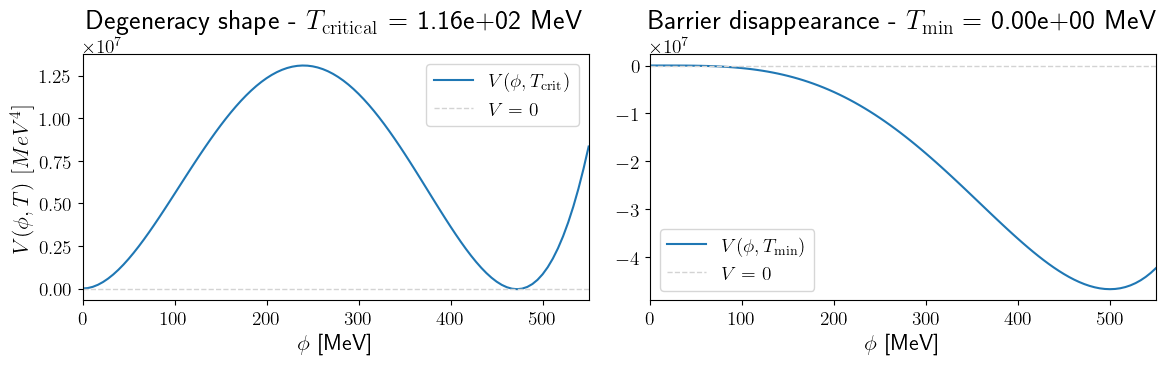

In [153]:
if T_max is not None: v_max = V(phi, T_max)
if T_min is not None: v_min = V(phi, T_min)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if T_max is not None: 
    v_max = V(phi, T_max)
    axes[0].plot(phi, v_max, label = '$V(\phi, T_\\mathrm{{crit}})$')
    axes[0].set_title(f'Degeneracy shape - $T_{{\\mathrm{{critical}}}}$ = {T_max:.2e} {units}')
    axes[0].set_xlim(phi[0], phi[-1])
    axes[0].set_ylabel(f"$V(\phi, T)$ $[{units}^{4}]$")

if T_min is not None: 
    v_min = V(phi, T_min)
    axes[1].plot(phi, v_min, label= '$V(\phi, T_\\mathrm{{min}})$')
    axes[1].set_title(f'Barrier disappearance - $T_{{\\mathrm{{min}}}}$ = {T_min:.2e} {units}')
    axes[1].set_xlim(phi[0], phi[-1])

for ax in axes:
    ax.set_xlabel(f"$\phi$ [{units}]")
    ax.axhline(false_min_tmax[1], color='lightgrey', linestyle='--', linewidth=1, label = "$V = 0$")
    ax.legend()

plt.tight_layout()
plt.show()

# Compute the tunneling action and several other usueful quantities over the relevant temperature range

Define the function that will collect the results of the instances of `espinosa.Vt_vec` for the different temperatures

In [154]:
from espinosa import Vt_vec

true_vev = {}
S3overT = {}
V_min_value = {}
phi0_min = {}
V_exit = {}
false_vev = {}

def action_over_T(T, c_step_phi = 1e-3, precision = 1e-3):
    instance = Vt_vec(T, V, dV, step_phi = c_step_phi, precision = precision, vev0 = maxvev)
    if instance.barrier:
        true_vev[T] = instance.true_min
        false_vev[T] = instance.phi_original_false_vev
        S3overT[T] = instance.action_over_T
        V_min_value[T] = instance.min_V
        phi0_min[T] = instance.phi0_min
        V_exit[T] = instance.V_exit
        return instance.action_over_T
    else:
        return None

## The cell below computes the tunneling action and other relevant quantities over a large number or temperatures between `T_min` and `T_max`

It stores the results in a collection of dictionaries, where the key is the temeperature and the value the quantity at that specific temperature. The quantities are:
- `S3overT`: the value of the finite-temperature 3-dimensional tunneling action $S_3$ divided by the temperature $T$, i.e. $S_3 / T$;
- `phi0_min`: the value of the field $\phi_{0, min}$ that minimises $S_{E,3}$, c.f. eq. (37) in 1805.03680;
- `V_exit`: the value of the potential at $V(\phi_{0, min})$;
- `true_vev`: location of the true vev;
- `false_vev`: location  of the false vev;
- `V_min_value`: the value of the potential at $V(true\ vev)$.

### This computation only needs to be performed once for a parameter point.

In [155]:
n_points = 100
temperatures = np.linspace(T_min, T_max, n_points)
action_vec = np.vectorize(action_over_T)

start_time = time.time()
action_vec(temperatures)
end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

temperatures = np.array([T for T in temperatures if T in S3overT])

Elapsed time: 1.88 seconds


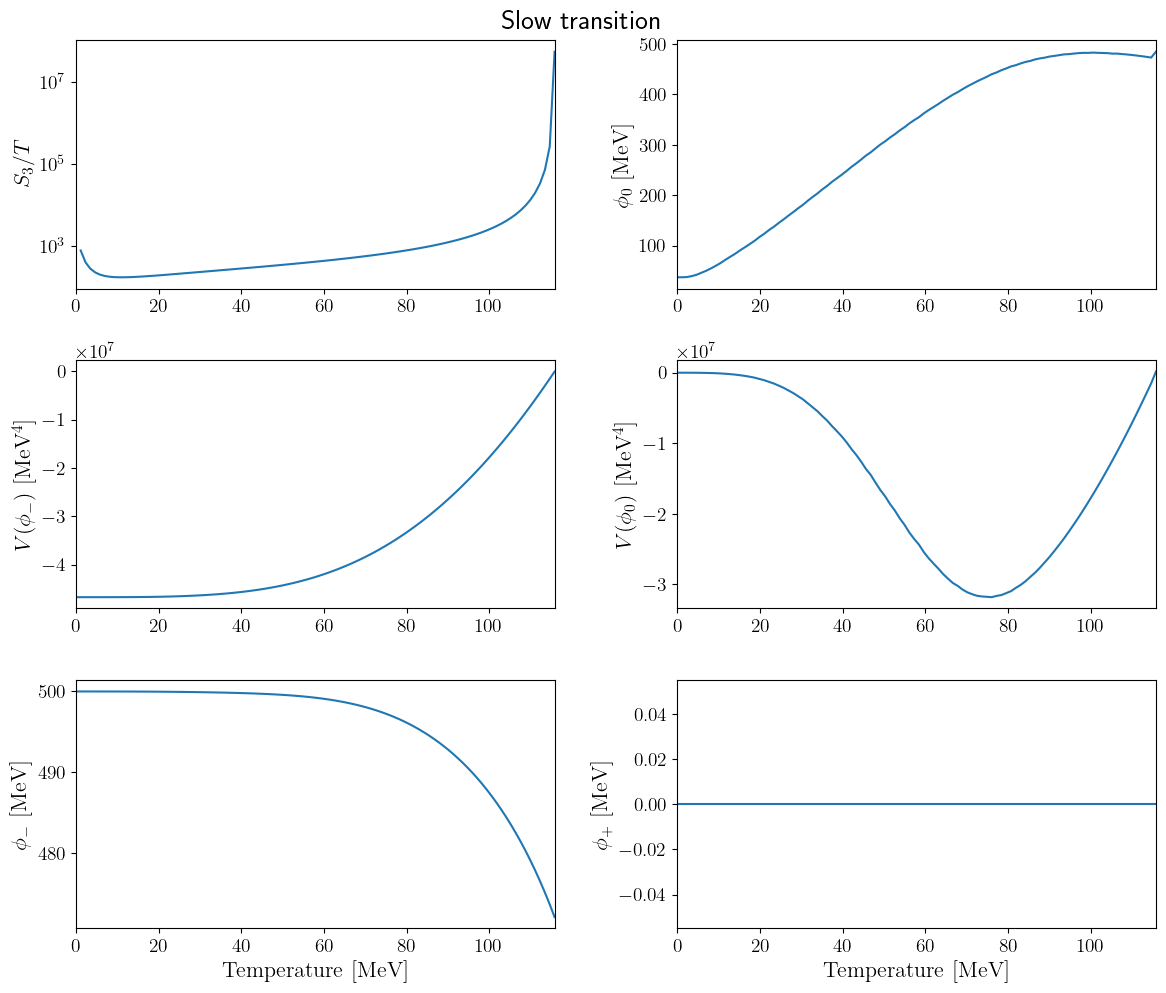

Minimum of the action at T = 1.17e+01 MeV


In [156]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

axes[0, 0].plot(temperatures, [S3overT[T] for T in temperatures])
#axes[0, 0].set_title('$S_3/T$')
#axes[0, 0].set_xlabel(f"T [{units}]")
axes[0, 0].set_ylabel('$S_3/T$')
axes[0, 0].set_yscale('log')

axes[0, 1].plot(temperatures, [phi0_min[T] for T in temperatures])
#axes[0, 1].set_title('$\phi_{0,\mathrm{min}}$')
#axes[0, 1].set_xlabel(f"T [{units}]")
axes[0, 1].set_ylabel(f"$\phi_0\ \mathrm{{[{units}]}}$")

axes[1, 0].plot(temperatures, [V_min_value[T] for T in temperatures])
#axes[1, 0].set_title('V(true_vev)')
#axes[1, 0].set_xlabel(f"T [{units}]")
axes[1, 0].set_ylabel(f"$V(\phi_-)\ \mathrm{{[{units}^4]}}$") # (f'$V_{{\\mathrm{{min}}}}\ [{units}^4]$')

axes[1, 1].plot(temperatures, [V_exit[T] for T in temperatures])
#axes[1, 1].set_title('$V(\phi_{0,\mathrm{min}})$')
#axes[1, 1].set_xlabel(f"T [{units}]")
axes[1, 1].set_ylabel(f"$V(\phi_0)\ \mathrm{{[{units}^4]}}$") # (f'$V_{{\\mathrm{{exit}}}}\ [{units}^4]$')

axes[2, 0].plot(temperatures, [true_vev[T] for T in temperatures])
#axes[2, 0].set_title('True vev')
axes[2, 0].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[2, 0].set_ylabel(f"$\phi_-\ \mathrm{{[{units}]}}$") # (f'$\\phi_{{\\mathrm{{true}}}}$ [{units}]')

axes[2, 1].plot(temperatures, [false_vev[T] for T in temperatures])
#axes[2, 1].set_title('False vev')
axes[2, 1].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[2, 1].set_ylabel(f"$\phi_+\ \mathrm{{[{units}]}}$") # (f'$\\phi_{{\\mathrm{{false}}}}$ [{units}]')

for ax in axes.flatten():
    ax.set_xlim(temperatures[0], temperatures[-1])

plt.tight_layout()
fig.suptitle(f'{description} transition', y=1.00)
plt.savefig(figure_dir + f"action_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Minimum of the action at T = {temperatures[np.argmin([S3overT[T] for T in temperatures])]:.2e} {units}")

# Computation of transition milestones

The cell below uses the above-computed results to compute the milestones of the transition (if any):
- `T_nuc`: the nucleation temperature;
- `T_perc`: the percolation temperature;
- `T_completion`: the completion temperature

If the condition that defines any of the above milestone temperatures is not met, the corresponding temeprature is set to a `nan` value.

The computation is performed two times: the first time spanning over the full range of relevant temperatures between `T_min` and `T_max`, to identify the scale of the transition milestone. The second time over a finer grid of temperature values between `T_completion` and `T_nuc`, to better integrate over the most important range of temperatures defining a first-order phase transition.

The variable `is_physical` is set to `True` if the physical volume of Universe in false vacuum is decreasing at percolation. In the opposite case, the production of GW is questionable (cf. e.g. Section 4.7.2 in [2305.02357] and references therein).

In [157]:
from utils import interpolation_narrow
from temperatures import compute_logP_f, N_bubblesH, R_sepH

is_physical = True

def is_increasing(arr):
    return np.all(arr[:-1] <= arr[1:])

counter = 0
while counter <= 1:
    if counter == 1:
        temperatures = np.linspace(np.nanmax([T_min, 0.95 * T_completion]), np.nanmin([T_max, 1.05 * T_nuc]), n_points, endpoint = True)
        action_vec(temperatures)
    logP_f, Temps, ratio_V, Gamma, H = compute_logP_f(dp, V_min_value, S3overT, v_w = 1, units = units, cum_method= 'None')
    RH, R = R_sepH(Temps, Gamma, logP_f, H, ratio_V)
    nH = N_bubblesH(Temps, Gamma, logP_f, H, ratio_V)
    mask_nH = ~np.isnan(nH)
    T_nuc = interpolation_narrow(np.log(nH[mask_nH]), Temps[mask_nH], 0)
    mask_Pf = ~np.isnan(logP_f)
    T_perc = interpolation_narrow(logP_f[mask_Pf], Temps[mask_Pf], np.log(0.71))
    T_completion = interpolation_narrow(logP_f[mask_Pf], Temps[mask_Pf], np.log(0.01))
    idx_compl = np.max([np.argmin(np.abs(Temps - T_completion)), 1])
    test_completion = np.array([logP_f[idx_compl - 1], logP_f[idx_compl], logP_f[idx_compl + 1]])
    test_completion = test_completion[~np.isnan(test_completion)]
    print(counter, T_completion, test_completion)
    print(is_increasing(test_completion))
    if not is_increasing(test_completion):
        T_completion = np.nan
    if counter == 1:
        d_dT_logP_f = np.gradient(logP_f, Temps)
        log_at_T_perc = interpolation_narrow(Temps, d_dT_logP_f, T_perc)
        ratio_V_at_T_perc = interpolation_narrow(Temps, ratio_V, T_perc)
        log_at_T_completion = interpolation_narrow(Temps, d_dT_logP_f, T_completion)
        ratio_V_at_T_completion = interpolation_narrow(Temps, ratio_V, T_completion)
        if ratio_V_at_T_perc > log_at_T_perc:
            is_physical = False
            print("\n *** The physical volume at percolation is not decreasing. The production of GW is questionable ***")
    counter += 1

milestones = [T_max, T_nuc, T_perc, T_completion, T_min]
milestones = [milestone for milestone in milestones if milestone is not None and not np.isnan(milestone)]
action_vec(milestones)

# This is just for plotting purposes
t_mil_min, t_mil_max = np.nanmin([T_completion, T_perc, T_nuc]), np.nanmax([T_completion, T_perc, T_nuc])
idx_min = max(np.argmin(np.abs(Temps - t_mil_min)), 0)
idx_max = min(np.argmin(np.abs(Temps - t_mil_max)), len(Temps) - 1)
idx_min = idx_min if Temps[idx_min] <= t_mil_min else idx_min - 1
idx_max = idx_max if Temps[idx_max] >= t_mil_max else idx_max + 1
mask = (Temps >= Temps[idx_min]) & (Temps <= Temps[idx_max]) if not np.isnan(t_mil_min) else Temps >= 0

print(f"\nT_nuc = {T_nuc:.6e} {units}")
print(f"T_perc = {T_perc:.6e} {units}")
print(f"T_completion = {T_completion:.6e} {units}\n")

0 6.53871842490114 [-6.48348581 -3.31339059 -1.435168  ]
True


/Users/michele/scratch/ELENA_release/src/temperatures.py:360: RuntimeWarning: invalid value encountered in multiply
  Gamma_list = Temps**4 * (S3_T / (2 * np.pi))**(3/2) * np.exp(-S3_T)
/Users/michele/scratch/ELENA_release/src/temperatures.py:374: RuntimeWarning: overflow encountered in exp
  f1 = ratio_V[i:] / H[i:] * np.exp(cum_ratio_V / 3.)
/Users/michele/scratch/ELENA_release/src/temperatures.py:377: RuntimeWarning: invalid value encountered in multiply
  f2 = f_ext[i:] * np.exp(- cum_ratio_V) * cum_f1**3
/Users/michele/scratch/ELENA_release/src/temperatures.py:407: RuntimeWarning: divide by zero encountered in power
  return n**(-1/3) * H, n**(-1/3)
/var/folders/04/fp1djbdn4s5976r1jm7nkrsw0000gn/T/ipykernel_53695/2969552134.py:18: RuntimeWarning: divide by zero encountered in log
  T_nuc = interpolation_narrow(np.log(nH[mask_nH]), Temps[mask_nH], 0)


1 6.38594908172147 [-4.83924522 -4.60549281 -4.37974565]
True

T_nuc = 1.393805e+01 MeV
T_perc = 9.607274e+00 MeV
T_completion = 6.385949e+00 MeV



/Users/michele/miniconda3/envs/elena/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2625: RuntimeWarning: invalid value encountered in action_over_T (vectorized)
  outputs = ufunc(*args, out=...)


# Plot the evolution of the physical volume in the false vacuum
The figures below check if $\mathcal{V}_{phys}$ as defined in (4.64 in 2305.02357) is decreasing at a given temperature. Percolation and the production of GW are questionable if the volume is increasing at `T_perc` for a parameter point. This does not necessarily mean that such points do not produce GW (for instance before of after `T_perc`), however the computation of the resulting GW spectrum requires dedicated simulations, making the expressions used in `ELENA` not suitable for a reliable prediction.

**Do not trust the resulting GW spectrum if the variable `is_physical` is `False`**


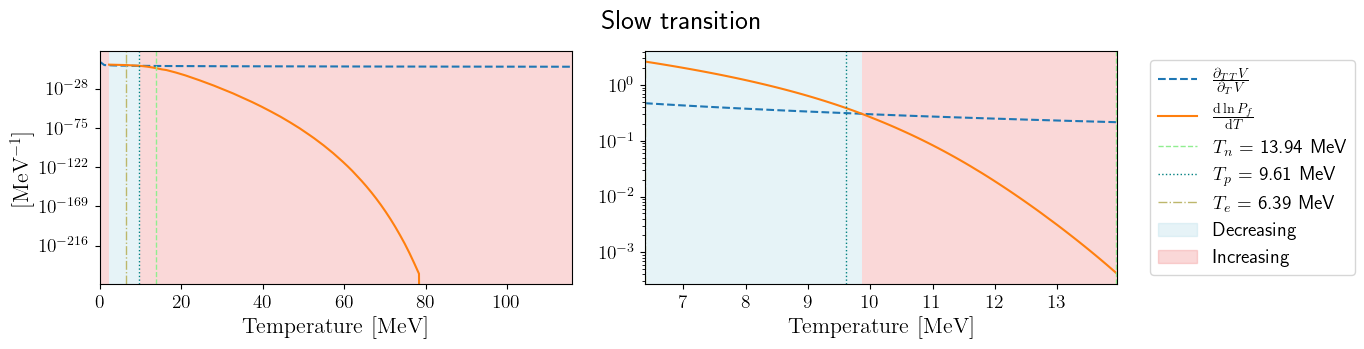

In [158]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# axes[0].plot(Temps, 3 / Temps, label = 'Bag model')
axes[0].plot(Temps, ratio_V, label = 'V_TT / V_T', linestyle='--')
axes[0].plot(Temps, d_dT_logP_f, label = 'd/dT log(P_f)')
axes[0].set_xlim(Temps[0], Temps[-1])
axes[0].set_ylabel(f"$\mathrm{{[{units}^{{-1}}]}}$") #(f'$[{units}^{{-1}}]$')

# axes[1].plot(Temps[mask], 3 / Temps[mask], label = 'Bag model')
axes[1].plot(Temps[mask], ratio_V[mask], label = r'$\frac{\partial_{TT} V}{\partial_T V}$', linestyle='--')
axes[1].plot(Temps[mask], d_dT_logP_f[mask], label = r'$\frac{\mathrm{d} \ln P_f}{\mathrm{d} T}$')

axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])

# Create the legend patches
decreasing_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='decreasing')
increasing_patch = mpatches.Patch(color='lightcoral', alpha=0.3, label='increasing')


for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}}$ = {T_nuc:.2f} {units}')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}}$ = {T_perc:.2f} {units}')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}}$ = {T_completion:.2f} {units}')
    # ax.axhline(log_at_T_perc, color='lightgrey', linestyle='--', linewidth=1, label = f"d/dT log(P_f) = {log_at_T_perc:.2e}")
    # ax.axhline(ratio_V_at_T_perc, color='lightgreen', linestyle=':', linewidth=1, label = f"V_TT / V_T = {ratio_V_at_T_perc:.2e}")
    for i in range(len(Temps) - 1):
        if d_dT_logP_f[i] >= ratio_V[i]:
            ax.axvspan(Temps[i], Temps[i + 1], facecolor='lightblue', alpha=0.3)
        else:
            ax.axvspan(Temps[i], Temps[i + 1], facecolor='lightcoral', alpha=0.3)

handles, labels = axes[1].get_legend_handles_labels()
handles.extend([decreasing_patch, increasing_patch])
labels.extend(['Decreasing', 'Increasing'])
axes[1].legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

fig.suptitle(f'{description} transition', y=0.89)
plt.tight_layout()
plt.savefig(figure_dir + f"volume_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

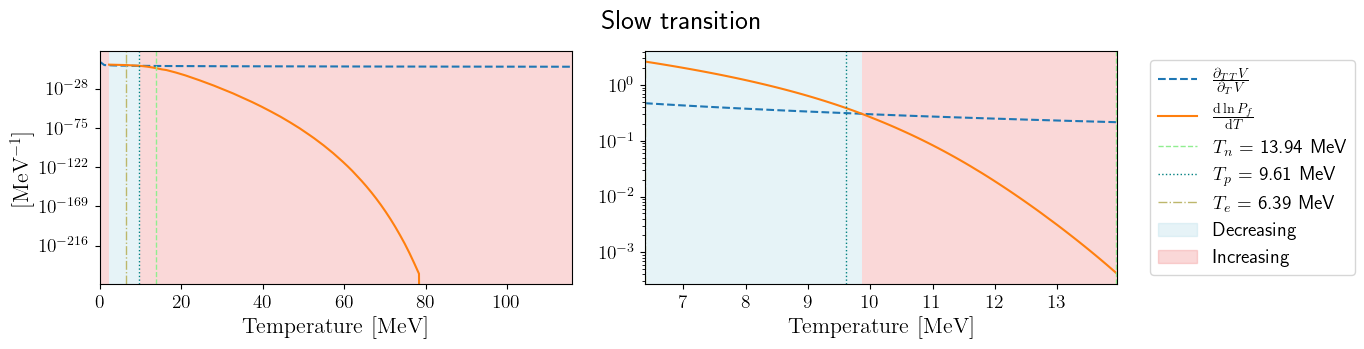

In [159]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot per il grafico intero
axes[0].plot(Temps, ratio_V, label = 'V_TT / V_T', linestyle='--')
axes[0].plot(Temps, d_dT_logP_f, label = 'd/dT log(P_f)')
axes[0].set_xlim(Temps[0], Temps[-1])
axes[0].set_ylabel(f"$\\mathrm{{[{units}^{{-1}}]}}$")

# Plot per la vista ingrandita
axes[1].plot(Temps[mask], ratio_V[mask], label = r'$\frac{\partial_{TT} V}{\partial_T V}$', linestyle='--')
axes[1].plot(Temps[mask], d_dT_logP_f[mask], label = r'$\frac{\mathrm{d} \ln P_f}{\mathrm{d} T}$')
axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])

# Create the legend patches
decreasing_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='decreasing')
increasing_patch = mpatches.Patch(color='lightcoral', alpha=0.3, label='increasing')

# Trova i punti di intersezione tra d_dT_logP_f e ratio_V
intersections = []
for i in range(len(Temps) - 1):
    # Controlla se c'è un'intersezione tra questi due punti
    if (d_dT_logP_f[i] - ratio_V[i]) * (d_dT_logP_f[i+1] - ratio_V[i+1]) <= 0:
        # Calcola il punto di intersezione esatto usando l'interpolazione lineare
        x1, x2 = Temps[i], Temps[i+1]
        y1, y2 = d_dT_logP_f[i] - ratio_V[i], d_dT_logP_f[i+1] - ratio_V[i+1]
        # Formula dell'intersezione con l'asse x (dove y = 0)
        intersection_x = x1 - y1 * (x2 - x1) / (y2 - y1)
        intersections.append(intersection_x)

# Aggiungi le intersezioni trovate ai punti originali per avere transizioni precise
all_points = np.sort(np.concatenate([Temps, intersections]))

for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xlabel(f"$\\mathrm{{Temperature\\ [{units}]}}$")
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}}$ = {T_nuc:.2f} {units}')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}}$ = {T_perc:.2f} {units}')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}}$ = {T_completion:.2f} {units}')
    
    # Colora lo sfondo usando i punti precisi delle intersezioni
    for i in range(len(all_points) - 1):
        # Trova il valore medio tra i due punti per determinare il colore
        mid_point = (all_points[i] + all_points[i+1]) / 2
        
        # Interpola il valore di d_dT_logP_f e ratio_V al punto medio
        d_dT_value = np.interp(mid_point, Temps, d_dT_logP_f)
        ratio_value = np.interp(mid_point, Temps, ratio_V)
        
        # Scegli il colore in base al confronto
        if d_dT_value >= ratio_value:
            ax.axvspan(all_points[i], all_points[i+1], facecolor='lightblue', alpha=0.3)
        else:
            ax.axvspan(all_points[i], all_points[i+1], facecolor='lightcoral', alpha=0.3)

handles, labels = axes[1].get_legend_handles_labels()
handles.extend([decreasing_patch, increasing_patch])
labels.extend(['Decreasing', 'Increasing'])
axes[1].legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

fig.suptitle(f'{description} transition', y=0.89)
plt.tight_layout()
plt.savefig(figure_dir + f"volume_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Plot the evolution of the transition

## Full range of temperatures

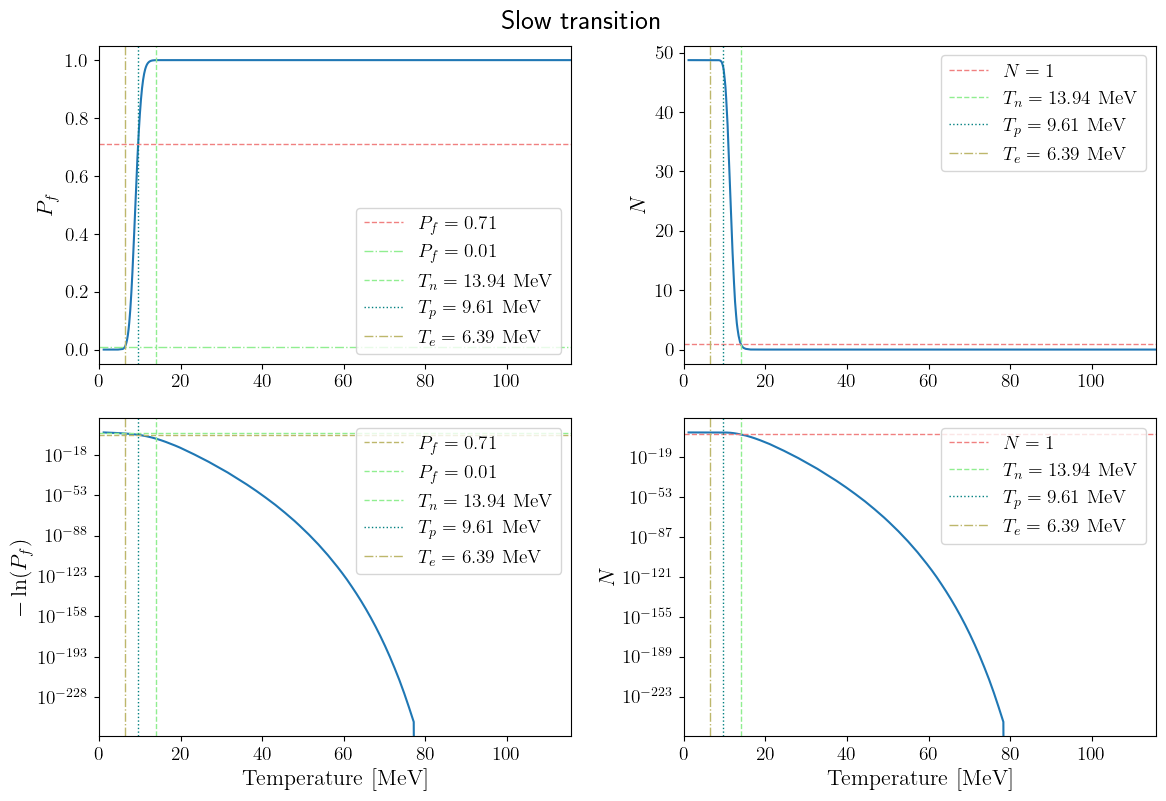

Average number of bubbles at T_min, N = 4.873e+01


In [160]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].plot(Temps, np.exp(logP_f))
#axes[0,0].set_title('Fraction of universe in false vacuum')
#axes[0,0].set_xlabel(f'T [{units}]')  
axes[0,0].set_ylabel('$P_f$')
axes[0,0].axhline(0.71, color='lightcoral', linestyle='--', linewidth=1, label=f'$P_f = 0.71$')
axes[0,0].axhline(0.01, color='lightgreen', linestyle='-.', linewidth=1, label=f'$P_f = 0.01$')
axes[0,0].legend()

axes[0,1].plot(Temps[mask_nH], nH[mask_nH])
axes[0,1].axhline(1, color='lightcoral', linestyle='--', linewidth=1, label=f'$N = 1$')
#axes[0,1].set_title('Bubbles per Hubble volume')
#axes[0,1].set_xlabel(f'Temperature [{units}]')
axes[0,1].set_ylabel('$N$')
axes[0,1].legend()

axes[1,0].plot(Temps, -logP_f)
axes[1,0].axhline(-np.log(0.71), color='darkkhaki', linestyle='--', linewidth=1, label=f'$P_f = 0.71$')
axes[1,0].axhline(-np.log(0.01), color='lightgreen', linestyle='--', linewidth=1, label=f'$P_f = 0.01$')
#axes[1,0].set_title('(minus) Log of fraction of universe in false vacuum')
axes[1,0].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,0].set_ylabel('$-\ln (P_f)$')
axes[1,0].set_yscale('log')
axes[1,0].legend()

axes[1,1].plot(Temps[mask_nH], nH[mask_nH])
axes[1,1].axhline(1, color='lightcoral', linestyle='--', linewidth=1, label=f'$N = 1$')
#axes[1,1].set_title('Bubbles per Hubble volume')
axes[1,1].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,1].set_ylabel('$N$')
axes[1,1].set_yscale('log')
axes[1,1].legend()

for ax in axes.flatten():
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}} = {T_nuc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}} = {T_perc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}} = {T_completion:.2f} \mathrm{{\ {units}}}$')
    ax.legend()

for ax in axes.flatten():
    ax.set_xlim(Temps[0], Temps[-1])

plt.tight_layout()
fig.suptitle(f'{description} transition', y=1.01)
plt.savefig(figure_dir + f"evolution_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Average number of bubbles at T_min, N = {nH[mask_nH][0]:.3e}")

## Range of temperatures zoomed over transition milestones

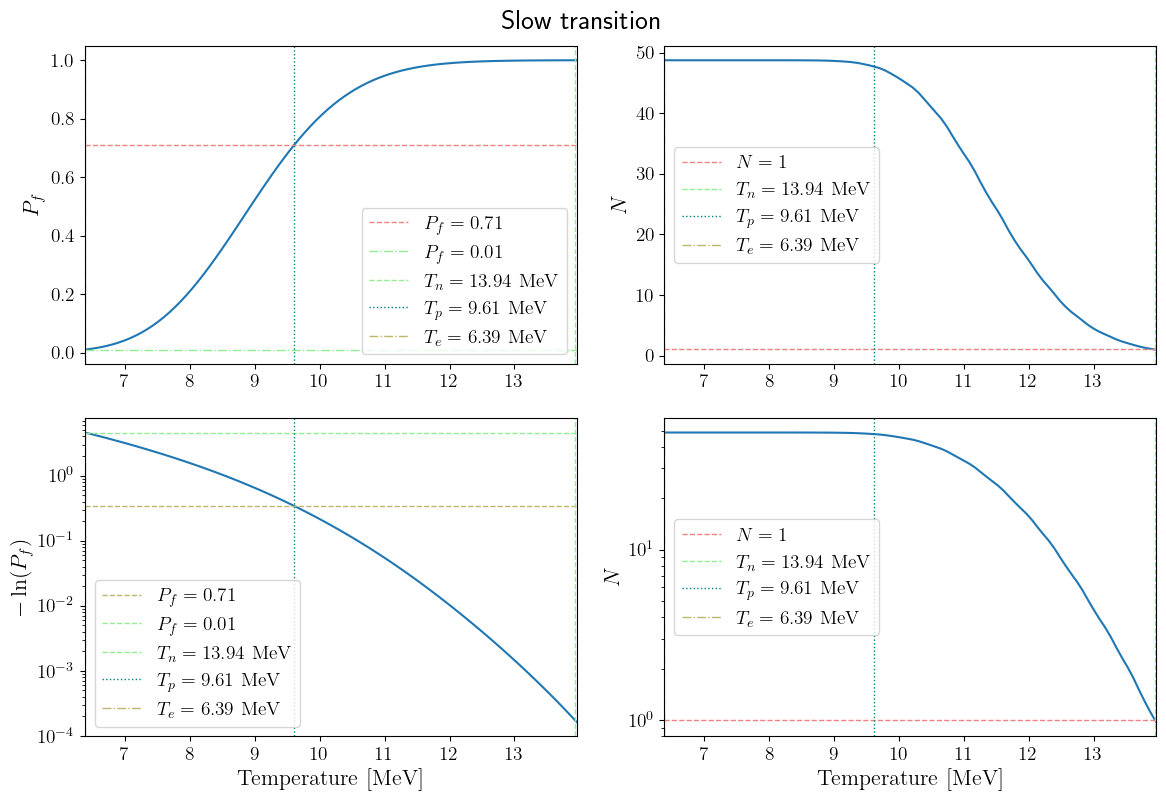

In [161]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].plot(Temps[mask], np.exp(logP_f[mask]))
#axes[0,0].set_title('Fraction of universe in false vacuum')
#axes[0,0].set_xlabel(f'T [{units}]')  
axes[0,0].set_ylabel('$P_f$')
axes[0,0].axhline(0.71, color='lightcoral', linestyle='--', linewidth=1, label=f'$P_f = 0.71$')
axes[0,0].axhline(0.01, color='lightgreen', linestyle='-.', linewidth=1, label=f'$P_f = 0.01$')
axes[0,0].legend()

axes[0,1].plot(Temps[mask], nH[mask])
axes[0,1].axhline(1, color='lightcoral', linestyle='--', linewidth=1, label=f'$N = 1$')
#axes[0,1].set_title('Bubbles per Hubble volume')
#axes[0,1].set_xlabel(f'Temperature [{units}]')
axes[0,1].set_ylabel('$N$')
axes[0,1].legend()

axes[1,0].plot(Temps[mask], -logP_f[mask])
axes[1,0].axhline(-np.log(0.71), color='darkkhaki', linestyle='--', linewidth=1, label=f'$P_f = 0.71$')
axes[1,0].axhline(-np.log(0.01), color='lightgreen', linestyle='--', linewidth=1, label=f'$P_f = 0.01$')
#axes[1,0].set_title('(minus) Log of fraction of universe in false vacuum')
axes[1,0].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,0].set_ylabel('$-\ln (P_f)$')
axes[1,0].set_yscale('log')
axes[1,0].legend()

axes[1,1].plot(Temps[mask], nH[mask])
axes[1,1].axhline(1, color='lightcoral', linestyle='--', linewidth=1, label=f'$N = 1$')
#axes[1,1].set_title('Bubbles per Hubble volume')
axes[1,1].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,1].set_ylabel('$N$')
axes[1,1].set_yscale('log')
axes[1,1].legend()

for ax in axes.flatten():
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}} = {T_nuc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}} = {T_perc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}} = {T_completion:.2f} \mathrm{{\ {units}}}$')
    ax.legend()

for ax in axes.flatten():
    ax.set_xlim(Temps[mask][0], Temps[mask][-1])

plt.tight_layout()
fig.suptitle(f'{description} transition', y=1.01)
plt.savefig(figure_dir + f"evolution_{description}_zoom.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Plot the tunneling quantities zoomed over milestone temperatures

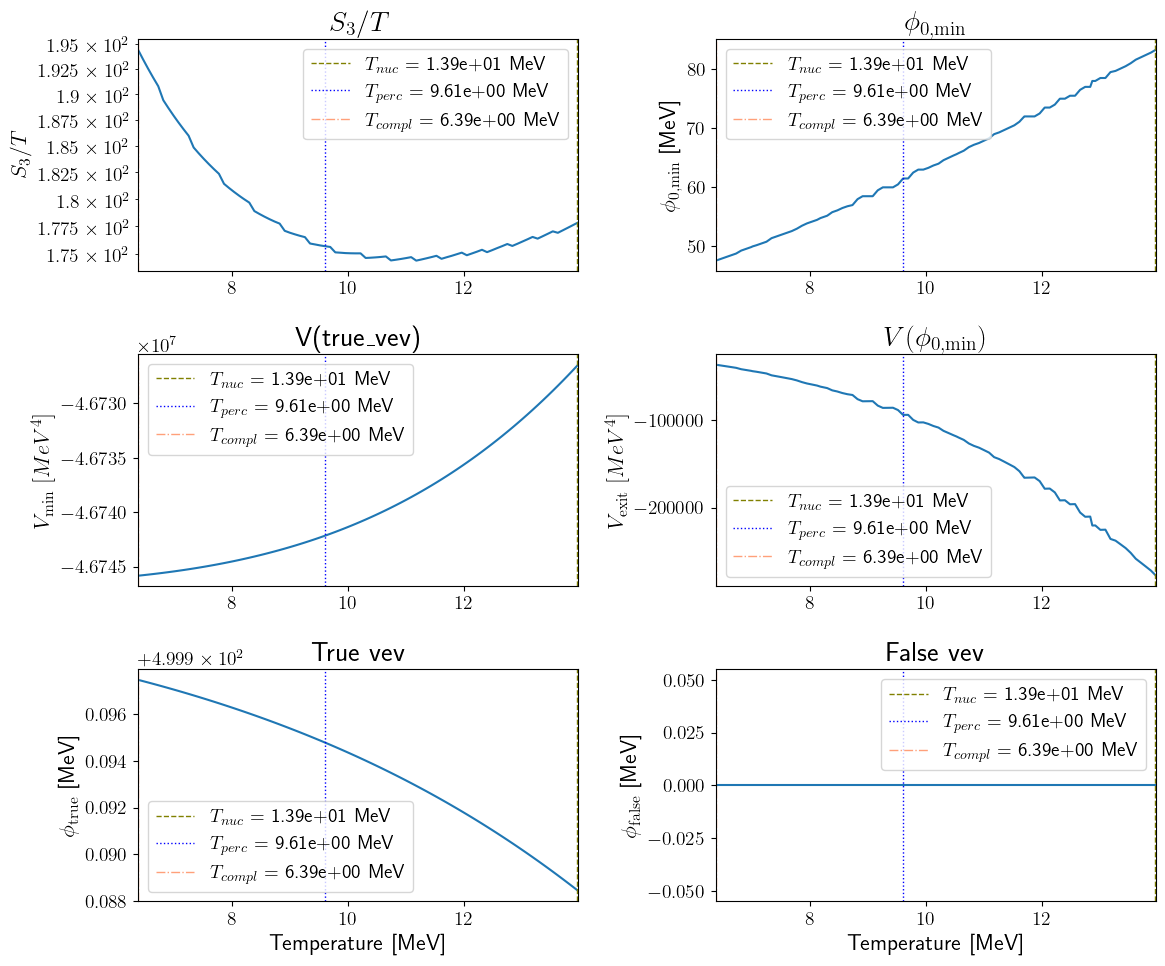

In [162]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

axes[0, 0].plot(Temps[mask], [S3overT[T] for T in Temps[mask]])
axes[0, 0].set_title('$S_3/T$')
#axes[0, 0].set_xlabel(f"T [{units}]")
axes[0, 0].set_ylabel('$S_3/T$')
axes[0, 0].set_yscale('log')

axes[0, 1].plot(Temps[mask], [phi0_min[T] for T in Temps[mask]])
axes[0, 1].set_title('$\phi_{0,\mathrm{min}}$')
#axes[0, 1].set_xlabel(f"T [{units}]")
axes[0, 1].set_ylabel(f'$\\phi_{{0,\\mathrm{{min}}}}$ [{units}]')

axes[1, 0].plot(Temps[mask], [V_min_value[T] for T in Temps[mask]])
axes[1, 0].set_title('V(true_vev)')
#axes[1, 0].set_xlabel(f"T [{units}]")
axes[1, 0].set_ylabel(f'$V_{{\\mathrm{{min}}}}\ [{units}^4]$')

axes[1, 1].plot(Temps[mask], [V_exit[T] for T in Temps[mask]])
axes[1, 1].set_title('$V(\phi_{0,\mathrm{min}})$')
#axes[1, 1].set_xlabel(f"T [{units}]")
axes[1, 1].set_ylabel(f'$V_{{\\mathrm{{exit}}}}\ [{units}^4]$')

axes[2, 0].plot(Temps[mask], [true_vev[T] for T in Temps[mask]])
axes[2, 0].set_title('True vev')
axes[2, 0].set_xlabel(f"Temperature [{units}]")
axes[2, 0].set_ylabel(f'$\\phi_{{\\mathrm{{true}}}}$ [{units}]')

axes[2, 1].plot(Temps[mask], [false_vev[T] for T in Temps[mask]])
axes[2, 1].set_title('False vev')
axes[2, 1].set_xlabel(f"Temperature [{units}]")
axes[2, 1].set_ylabel(f'$\\phi_{{\\mathrm{{false}}}}$ [{units}]')

for ax in axes.flatten():
    ax.axvline(T_nuc, color='olive', linestyle='--', linewidth=1, label=f'$T_{{nuc}}$ = {T_nuc:.2e} {units}')
    ax.axvline(T_perc, color='blue', linestyle=':', linewidth=1, label=f'$T_{{perc}}$ = {T_perc:.2e} {units}')
    ax.axvline(T_completion, color='lightsalmon', linestyle='-.', linewidth=1, label=f'$T_{{compl}}$ = {T_completion:.2e} {units}')
    ax.set_xlim(Temps[mask][0], Temps[mask][-1])
    ax.legend()

plt.tight_layout()
plt.show()

# Computation of thermal parameters determining the GW production

# $\alpha$ computation

The cell below computes the sound-speed in the plasma, that generally differs from the bag-model

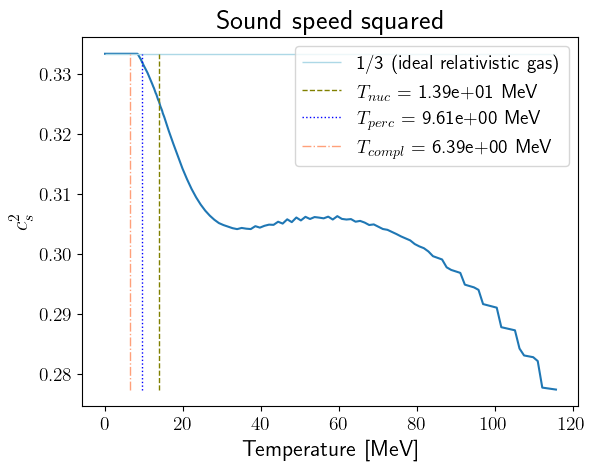

In [163]:
from GWparams import cs2

if T_perc is not None:
    action_over_T(T_perc)
    c_s2 = cs2(T_perc, dp, true_vev, units = units)

y = [cs2(T, dp, true_vev, units = units) for T in Temps]
plt.plot(Temps, y)
plt.hlines(1/3, Temps[0], Temps[-1], color='lightblue', linestyle='-', linewidth=1, label='1/3 (ideal relativistic gas)')
plt.vlines(T_nuc, np.nanmin(y), np.nanmax([np.nanmax(y), (1+1e-4) * 1/3]), color='olive', linestyle='--', linewidth=1, label=f'$T_{{nuc}}$ = {T_nuc:.2e} {units}')
plt.vlines(T_perc, np.nanmin(y), np.nanmax([np.nanmax(y), (1+1e-4) * 1/3]), color='blue', linestyle=':', linewidth=1, label=f'$T_{{perc}}$ = {T_perc:.2e} {units}')
plt.vlines(T_completion, np.nanmin(y), np.nanmax([np.nanmax(y), (1+1e-4) * 1/3]), color='lightsalmon', linestyle='-.', linewidth=1, label=f'$T_{{compl}}$ = {T_completion:.2e} {units}')
plt.title('Sound speed squared')
plt.xlabel(f'Temperature [{units}]')
plt.ylabel('$c_s^2$')
plt.legend()
plt.show()

The cell below contains the importation/definitions of:
- $\alpha$: following (5.29) in 2305.02357;
- $\alpha_\infty$: following 1004.4187;
- $\alpha_{eq}$: following 1903.09642.

In [164]:
from GWparams import alpha_th_bar # This is the definition of \alpha

def c_alpha_inf(T, units):
    v_true = true_vev[T]
    v_false = false_vev[T]
    Dm2_photon = 3 * g**2 * (v_true**2 - v_false**2)
    Dm2_scalar = 3 * lambda_ * (v_true**2 - v_false**2) 
    numerator = (Dm2_photon + Dm2_scalar) * T**2 / 24
    rho_tot = - T * 3 * (dp.dVdT(v_false, T, include_radiation=True, include_SM = True, units = units) ) / 4
    rho_DS = - T * 3 * (dp.dVdT(v_false, T, include_radiation=True, include_SM = False, units = units) ) / 4
    return numerator/ rho_tot, numerator / rho_DS

def c_alpha_eq(T, units):
    v_true = true_vev[T]
    v_false = false_vev[T]
    numerator = (g**2 * 3 * (g * (v_true - v_false)) * T**3)
    rho_tot = - T * 3 * (dp.dVdT(v_false, T, include_radiation=True, include_SM = True, units = units) ) / 4
    rho_DS = - T * 3 * (dp.dVdT(v_false, T, include_radiation=True, include_SM = False, units = units) ) / 4
    return numerator / rho_tot, numerator / rho_DS

The cell below computes the alphas at percolation. If `alpha < alpha_inf` the bubble nucleation is not in runaway regime, implying that the wall velocity $v_w$ does not converge asymptotically to 1. GW are still possible in this regime, however the computation of the transition temperatures and thermal parameters above is not reliable, since it assumes $v_w \rightarrow 1$. Thus the final GW spectrum should not be trust in this regime.

In [165]:
alpha, alpha_DS = alpha_th_bar(T_perc, dp, V_min_value, false_vev, true_vev, units = units)
alpha_inf, alpha_inf_DS = c_alpha_inf(T_perc, units)
alpha_eq, alpha_eq_DS = c_alpha_eq(T_perc, units)

gamma_eq = (alpha - alpha_inf) / alpha_eq
print(f"alpha = {alpha}")
print(f"alpha_inf = {alpha_inf}")
print(f"alpha_eq = {alpha_eq}")
print(f"gamma_eq = {gamma_eq}")

if alpha < alpha_inf:
    is_physical = False
    print("\n*** Warning, the bubble expansion is not in runaway regime! The results of the computation are not reliable ***")

alpha = 985.5130051198414
alpha_inf = 34.451640226780746
alpha_eq = 11.790195383239391
gamma_eq = 80.66544565029538


/var/folders/04/fp1djbdn4s5976r1jm7nkrsw0000gn/T/ipykernel_53695/2147266975.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return numerator/ rho_tot, numerator / rho_DS
/var/folders/04/fp1djbdn4s5976r1jm7nkrsw0000gn/T/ipykernel_53695/2147266975.py:19: RuntimeWarning: invalid value encountered in scalar divide
  return numerator / rho_tot, numerator / rho_DS


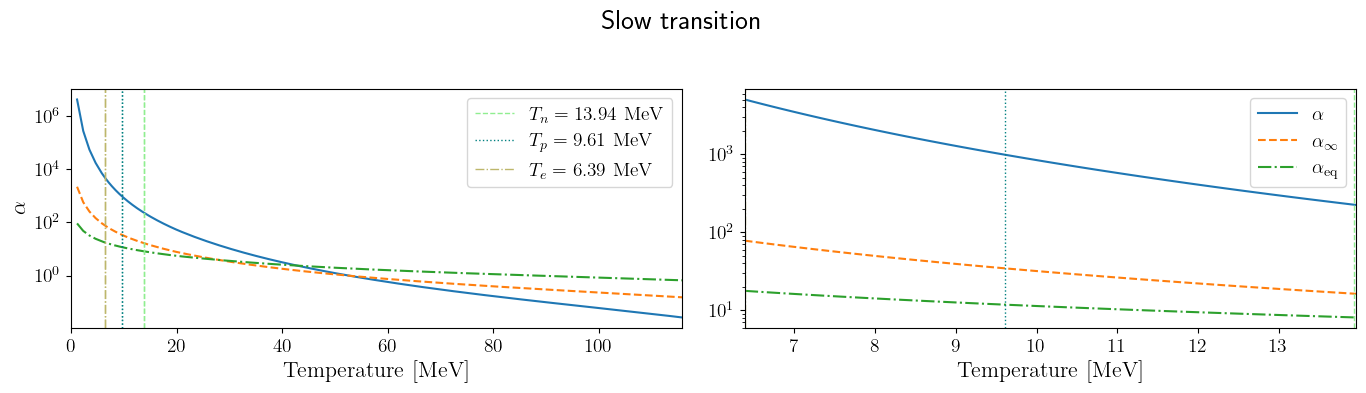

In [166]:
alpha_T = np.array([alpha_th_bar(T, dp, V_min_value, false_vev, true_vev, units)[0] for T in Temps])
alpha_inf_T = np.array([c_alpha_inf(t, units)[0] for t in Temps])
alpha_eq_T = np.array([c_alpha_eq(t, units)[0] for t in Temps])

amin, amax = min([np.nanmin(alpha_T), np.nanmin(alpha_inf_T), np.nanmin(alpha_eq_T)]), max([np.nanmax(alpha_T), np.nanmax(alpha_inf_T), np.nanmax(alpha_eq_T)])

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(Temps, alpha_T,linestyle='-') #label='$\\alpha$')
axes[0].plot(Temps, alpha_inf_T, linestyle='--') #label='$\\alpha_\infty$', )
axes[0].plot(Temps, alpha_eq_T,  linestyle='-.') #label='$\\alpha_\\mathrm{eq}$',)
axes[0].axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}} = {T_nuc:.2f} \mathrm{{\ {units}}}$')
axes[0].axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}} = {T_perc:.2f} \mathrm{{\ {units}}}$')
axes[0].axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}} = {T_completion:.2f} \mathrm{{\ {units}}}$')
axes[0].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[0].set_ylabel('$\\alpha$')
axes[0].set_yscale('log')
axes[0].set_xlim(Temps[0], Temps[-1])
axes[0].legend()

amin, amax = min([np.nanmin(alpha_T[mask]), np.nanmin(alpha_inf_T[mask]), np.nanmin(alpha_eq_T[mask])]), max([np.nanmax(alpha_T[mask]), np.nanmax(alpha_inf_T[mask]), np.nanmax(alpha_eq_T[mask])])
axes[1].plot(Temps[mask], alpha_T[mask], label='$\\alpha$', linestyle='-')
axes[1].plot(Temps[mask], alpha_inf_T[mask], label='$\\alpha_\infty$', linestyle='--')
axes[1].plot(Temps[mask], alpha_eq_T[mask], label='$\\alpha_\\mathrm{eq}$', linestyle='-.')
# axes[1].vlines(T_nuc, amin, amax, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}} = {T_nuc:.2f} \mathrm{{\ {units}}}$')
# axes[1].vlines(T_perc,amin, amax, color='lightblue', linestyle='-.', linewidth=1, label=f'$T_{{p}} = {T_perc:.2f} \mathrm{{\ {units}}}$')
axes[1].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
#axes[1].set_ylabel('$\\alpha$')
axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])

y_min, y_max = axes[1].get_ylim()
if 0.1 <= y_min and y_max <= 1:
    axes[1].ticklabel_format(axis='y', style='sci', scilimits=(-1,-1))
else:
    axes[1].set_yscale('log')
axes[1].legend()

# handles, labels = axes[1].get_legend_handles_labels()
# axes[1].legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

for ax in axes.flatten():
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}} = {T_nuc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}} = {T_perc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}} = {T_completion:.2f} \mathrm{{\ {units}}}$')
    #custom_y_formatter(ax)

#fig.suptitle(f'Alpha comparison - {description}')
fig.suptitle(f'{description} transition', y=1.00)
plt.savefig(figure_dir + f"alpha_{description}.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Compute the mean bubble separation

In [167]:
from temperatures import R_sepH

RH, R = R_sepH(Temps, Gamma, logP_f, H, ratio_V)
RH_interp = interpolation_narrow(Temps, RH, T_perc)
H_star = interpolation_narrow(Temps, H, T_perc)
R_star = RH_interp / H_star

print(f"R* H* = {RH_interp:.2e}")

R* H* = 5.29e-01


/Users/michele/scratch/ELENA_release/src/temperatures.py:407: RuntimeWarning: divide by zero encountered in power
  return n**(-1/3) * H, n**(-1/3)


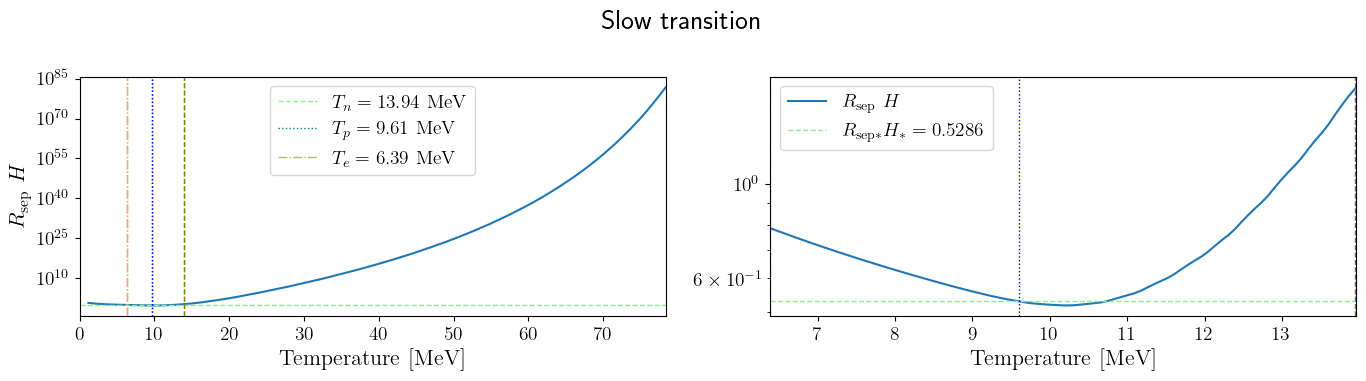

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(Temps, RH) #, label = '$R H$')
axes[0].set_ylabel('$R_\mathrm{sep}\ H$')
axes[0].set_yscale('log')
axes[0].axhline(RH_interp, color='lightgreen', linestyle='--', linewidth=1) #, label=f'$R_* H_* = {RH_interp:.4f}$')
axes[0].axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}} = {T_nuc:.2f} \mathrm{{\ {units}}}$')
axes[0].axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}} = {T_perc:.2f} \mathrm{{\ {units}}}$')
axes[0].axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}} = {T_completion:.2f} \mathrm{{\ {units}}}$')
axes[0].set_xlim(Temps[0], Temps[np.max(np.where(RH < np.inf)[0])])
axes[0].legend()

axes[1].plot(Temps[mask], RH[mask], label = '$R_\mathrm{sep}\ H$')
#axes[1].set_ylabel('$R\ H$')
axes[1].set_yscale('log')
axes[1].axhline(RH_interp, color='lightgreen', linestyle='--', linewidth=1, label=f'$R_\mathrm{{sep *}} H_* = {RH_interp:.4f}$')
axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])
axes[1].legend()

for ax in axes.flatten():
    ax.axvline(T_nuc, color='olive', linestyle='--', linewidth=1, label=f'$T_{{nuc}}$ = {T_nuc:.2e} {units}')
    ax.axvline(T_perc, color='blue', linestyle=':', linewidth=1, label=f'$T_{{perc}}$ = {T_perc:.2e} {units}')
    ax.axvline(T_completion, color='lightsalmon', linestyle='-.', linewidth=1, label=f'$T_{{compl}}$ = {T_completion:.2e} {units}')
    ax.set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")

# handles, labels = axes[1].get_legend_handles_labels()
# axes[1].legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

#fig.suptitle(f'Mean bubble separation - {description}')
fig.suptitle(f'{description} transition', y=0.97)
plt.savefig(figure_dir + f"RH_{description}.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Compute the efficiency factors

The cell below computes the efficiency factors of the transition following the expressions in 1903.09642.

/Users/michele/scratch/ELENA_release/src/temperatures.py:411: RuntimeWarning: invalid value encountered in scalar multiply
  E0V = S3_T[T] * T / 2 # this is the potential energy contribution only
/Users/michele/scratch/ELENA_release/src/temperatures.py:413: RuntimeWarning: invalid value encountered in power
  r0 = ((3 * E0V / (4*np.pi*DV))**(1/3.0))


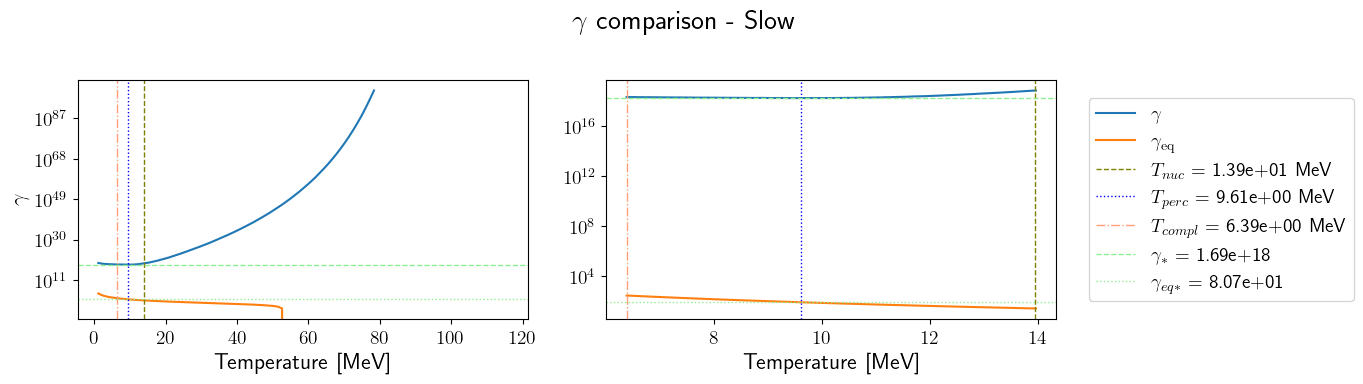

In [169]:
from temperatures import R0

r0 = np.array([R0(T, S3overT, V_exit) for T in Temps])

gamma_eq_T = (alpha_T - alpha_inf_T) / alpha_eq_T
gamma = 2 * R / (3 * r0)

gamma_star = 2 * R_star / (3 * R0(T_perc, S3overT, V_exit))
gamma_eq_star = interpolation_narrow(Temps, gamma_eq_T, T_perc)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(Temps, gamma, label='$\gamma$')
axes[0].plot(Temps, gamma_eq_T, label='$\gamma_\mathrm{eq}$')
axes[0].set_yscale('log')
axes[0].set_xlabel(f'Temperature [{units}]')
axes[0].set_ylabel('$\gamma$')

axes[1].plot(Temps[mask], gamma[mask], label='$\gamma$')
axes[1].plot(Temps[mask], gamma_eq_T[mask], label='$\gamma_\mathrm{eq}$')
axes[1].set_yscale('log')
axes[1].set_xlabel(f'Temperature [{units}]')
#axes[1].set_ylabel('$\gamma$')
axes[1].legend()

for ax in axes.flatten():
    ax.axvline(T_nuc, color='olive', linestyle='--', linewidth=1, label=f'$T_{{nuc}}$ = {T_nuc:.2e} {units}')
    ax.axvline(T_perc, color='blue', linestyle=':', linewidth=1, label=f'$T_{{perc}}$ = {T_perc:.2e} {units}')
    ax.axvline(T_completion, color='lightsalmon', linestyle='-.', linewidth=1, label=f'$T_{{compl}}$ = {T_completion:.2e} {units}')
    ax.axhline(gamma_star, color='lightgreen', linestyle='--', linewidth=1, label=f'$\gamma_*$ = {gamma_star:.2e}')
    ax.axhline(gamma_eq_star, color='lightgreen', linestyle=':', linewidth=1, label=f'$\gamma_{{eq*}}$ = {gamma_eq_star:.2e}')

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

fig.suptitle(f'$\gamma$ comparison - {description}')
plt.tight_layout()
plt.show()

# Check the nucleation process

The cells below fit the nucleation rate around the nucleation time to the relation 
$$
\Gamma(t - t_n) = H_n^4 \exp\left[\beta (t - t_n) - \frac{1}{2} \gamma^2 (t - t_n)^2 \right],
$$
where $H_n = H(t = t_n)$ is the Hubble rate at the nucleation time $t_n$ (defined as the time when $T = T_{nuc}$). The fit is performed until percolation.

If $\gamma / \beta \ll 1$ the nucleation process is exponential, otherwise second order corrections are important.

In [170]:
from GWparams import beta

logP_f, Temps, ratio_V, Gamma, H = compute_logP_f(dp, V_min_value, S3overT, v_w = 1, units = units, cum_method= 'None')

beta_Hn, gamma_Hn, times, Gamma_t, Temps_t, H_t = beta(Temps, ratio_V, Gamma, H, T_nuc, T_perc, verbose = True)

print("beta =", beta_Hn)
print("gamma =", gamma_Hn)

beta = 23.70701258814537
gamma = 10.86329772083537


/Users/michele/scratch/ELENA_release/src/temperatures.py:360: RuntimeWarning: invalid value encountered in multiply
  Gamma_list = Temps**4 * (S3_T / (2 * np.pi))**(3/2) * np.exp(-S3_T)
/Users/michele/scratch/ELENA_release/src/temperatures.py:374: RuntimeWarning: overflow encountered in exp
  f1 = ratio_V[i:] / H[i:] * np.exp(cum_ratio_V / 3.)
/Users/michele/scratch/ELENA_release/src/temperatures.py:377: RuntimeWarning: invalid value encountered in multiply
  f2 = f_ext[i:] * np.exp(- cum_ratio_V) * cum_f1**3


Below we plot the results:

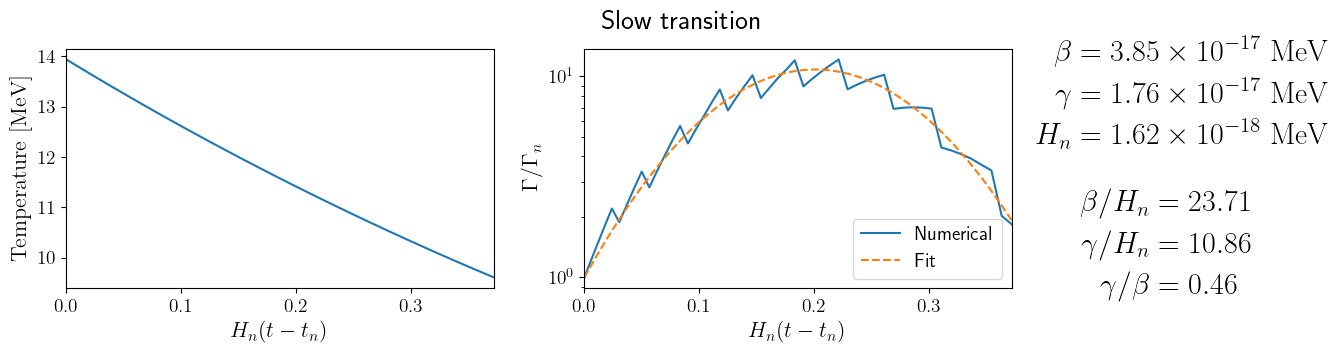

Percolation at 3.72e-01


In [171]:
Gamma_n = Gamma_t[0]
H_n = H_t[0]

def scientific_notation(number):
    exponent = int(np.floor(np.log10(abs(number))))
    coefficient = number / 10**exponent
    return f"{coefficient:.2f} \\times 10^{{{exponent}}}"

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(times, Temps_t)
axes[0].set_xlabel("$H_n (t-t_n)$")
axes[0].set_ylabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[0].set_xlim((times)[0], (times)[-1])


box_text = r"$\begin{aligned}" + \
           rf"\beta &= {scientific_notation(beta_Hn*H_n)}\ \mathrm{{{units}}}" + r"\\" + \
           rf"\gamma &= {scientific_notation(gamma_Hn*H_n)}\ \mathrm{{{units}}}" + r"\\" + \
           rf"H_n &= {scientific_notation(H_n)}\ \mathrm{{{units}}}" + \
           r"\end{aligned}$" + \
           r"\\[1em]" + \
           r"$\begin{aligned}" + \
           rf"\phantom{{AAA}} \beta / H_n &= {beta_Hn:.2f}" + r"\\" + \
           rf" \gamma / H_n &= {gamma_Hn:.2f}" + r"\\" + \
           rf" \gamma / \beta &= {gamma_Hn/beta_Hn:.2f}" + \
           r"\end{aligned}$"

axes[1].plot(times, Gamma_t / Gamma_t[0], label ="Numerical")
tfit = np.linspace(times[0], times[-1], 100, endpoint=True)
axes[1].plot(tfit, np.exp(beta_Hn*tfit - (gamma_Hn*tfit)**2 / 2), label = "Fit", linestyle='--')
axes[1].set_xlabel("$H_n (t-t_n)$")
axes[1].set_ylabel("$\Gamma / \Gamma_n$")
#axes[1].set_title(f"Decay rate - {description}")
axes[1].set_yscale('log')
axes[1].set_xlim(times[0], times[-1])
axes[1].text(1.4, 0.5, box_text,       # coordinates (0-1 for normalized)
        fontsize='large',
        transform=axes[1].transAxes,       # use normalized coordinates
        horizontalalignment='center',      # center text horizontally
        verticalalignment='center')        # center text vertically 
axes[1].legend()

plt.suptitle(f'{description} transition', y=0.9)
plt.tight_layout()
plt.savefig(figure_dir + f"nucleation_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Percolation at {times[-1]:.2e}")

# Compute gravitational waves spectrum

We import the periodograms from the NANOGrav 15-years dataset

In [172]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the original figure
with open('../data/processed/plots/NG15.pkl', 'rb') as f:
    fig, ax = pickle.load(f)

# Create a new figure with linear scales
fig_linear, ax_linear = plt.subplots(figsize=fig.get_size_inches())

# Extract and convert all collections from the logarithmic plot
for i, collection in enumerate(ax.collections):
    if hasattr(collection, 'get_paths') and len(collection.get_paths()) > 0:
        # Extract path data
        path = collection.get_paths()[0]
        vertices = path.vertices
        
        if len(vertices) > 0:
            x_log = vertices[:, 0]  # Log10 values
            y_log = vertices[:, 1]  # Log10 values
            
            # Convert to linear scale
            x_linear = 10**x_log
            y_linear = 10**y_log
            
            # Plot with original styling
            ax_linear.fill(x_linear, y_linear, 
                          facecolor=collection.get_facecolor()[0],
                          edgecolor=collection.get_edgecolor()[0],
                          alpha=collection.get_alpha())

# Set linear scales
ax_linear.set_xscale('linear')
ax_linear.set_yscale('linear')

# Copy labels from original
ax_linear.set_xlabel(ax.get_xlabel())
ax_linear.set_ylabel(ax.get_ylabel())
ax_linear.set_title(ax.get_title())

plt.close(fig)
plt.close(fig_linear)

Plot the gravitational waves spectrum over large range of frequency (default $[10^{-10}, 10^{10}]$ hz), following the expressions in 1903.09642.

Is physical? True
lambda = 0.006
g = 0.75002
vev = 500 MeV
m_phi = 54.772255750516614 MeV
m_Z = 375.01 MeV
T_crit = 115.75 MeV
T_nuc = 13.93805315494274 MeV
T_perc = 9.607274117323195 MeV
T_completion = 6.38594908172147 MeV
T_min = 0 MeV
T_reh = 53.84258297583765 MeV
Minimal value of P_f = 6.565160382796189e-17
alpha = 985.5130051198414, alpha_inf = 34.451640226780746, alpha_eq = 11.790195383239391
gamma_* = 1.6873494376225344e+18, gamma_eq = 80.66544565029538
Is runaway? True
RH = 0.5285939156592356


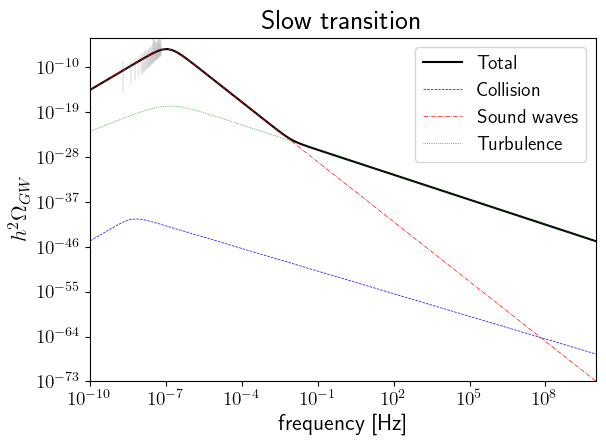

In [173]:
import pickle 
from GWparams import GW_SuperCooled
import contextlib

def print_params():
    print(f"Is physical? {is_physical}")
    print(f"lambda = {lambda_}")
    print(f"g = {g}")
    print(f"vev = {vev} {units}")
    print(f"m_phi = {np.sqrt(2*lambda_)*vev} {units}")
    print(f"m_Z = {g*vev} {units}")
    print(f"T_crit = {T_max} {units}")
    print(f"T_nuc = {T_nuc} {units}")
    print(f"T_perc = {T_perc} {units}")
    print(f"T_completion = {T_completion} {units}")
    print(f"T_min = {T_min} {units}")
    print(f"T_reh = {(1+alpha)**(1/4) * T_perc} {units}")
    print(f"Minimal value of P_f = {np.nanmin(np.exp(logP_f))}")
    print(f"alpha = {alpha}, alpha_inf = {alpha_inf}, alpha_eq = {alpha_eq}")
    print(f"gamma_* = {gamma_star}, gamma_eq = {gamma_eq}")
    print(f"Is runaway? {alpha > alpha_inf}")
    print(f"RH = {R_star * H_star}")
    #print(f"beta/H_n = {beta_H0}, gamma/H_n = {gamma_H0}, gamma/beta = {gamma_H0/beta_H0}")

# Save the relevant reults to a file
with open(f'../data/processed/plots/{description}.txt', 'w') as f:
    with contextlib.redirect_stdout(f):
        print_params()

log_freq_min = -10
log_freq_max = 10

if T_perc is not None:
    inst = GW_SuperCooled(T_perc, alpha, alpha_inf, alpha_eq, R_star, gamma_star, H_star, c_s = np.sqrt(c_s2), units = units)
    print_params()

    x = np.linspace(log_freq_min, log_freq_max, 100)
    x = 10**x
    ax_linear.plot(x, inst.Omegah2(x), label = "Total", color='black')
    ax_linear.plot(x, inst.Omegah2coll(x), label = "Collision", linewidth=0.5, color='blue', linestyle='--')
    ax_linear.plot(x, inst.Omegah2sw(x), label = "Sound waves", linewidth=0.5, color='red', linestyle='-.')
    ax_linear.plot(x, inst.Omegah2turb(x), label = "Turbulence", linewidth=0.5, color='green', linestyle=':')
    ax_linear.set_xlim(x[0], x[-1])
    ax_linear.set_ylim(1e-73, 1e-4)
    ax_linear.set_xscale('log')
    ax_linear.set_yscale('log')
    ax_linear.set_xlabel('frequency [Hz]')
    ax_linear.set_ylabel('$h^2 \Omega_{GW}$')
    #plt.title(f'GW spectrum - {description}')
    ax_linear.legend()
    ax_linear.set_title(f'{description} transition', y=1)
    fig_linear.savefig(figure_dir + f"GW_{description}.pdf", dpi=300, bbox_inches='tight')
    fig_linear.tight_layout()

# Save the for spectrum future plotting
if is_physical:
    with open(f'../data/processed/plots/GW_{description}.pkl', 'wb') as f:
        pickle.dump(inst, f)

fig_linear

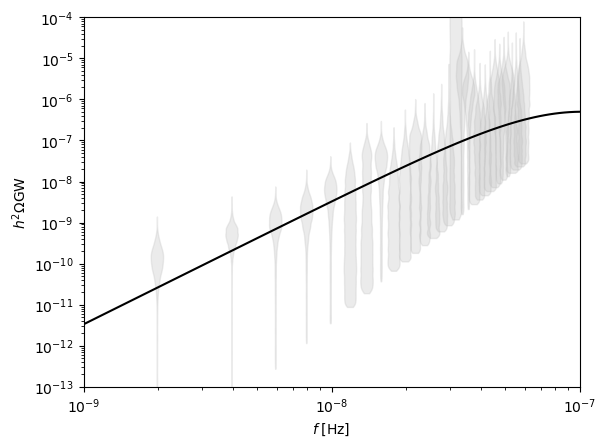

In [174]:
from matplotlib import ticker
import contextlib

def myticks(x,pos):
    exponent = int(x)
    coeff = x/10**exponent
    return r"$10^{{ {:2d} }}$".format(exponent)

with open('../data/processed/plots/NG15.pkl', 'rb') as f:
    fig, ax = pickle.load(f)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(myticks))
major = np.linspace(-100, 100, 201)
ax.xaxis.set_major_locator(ticker.FixedLocator(major))
minors = np.array([ -50+(np.floor(i/10)+np.log10(1+10*(i/10-np.floor(i/10)))) for i in np.arange(1,1000,1)])
ax.xaxis.set_minor_locator(ticker.FixedLocator(minors))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(myticks))
major = np.linspace(-100, 100, 201)
ax.yaxis.set_major_locator(ticker.FixedLocator(major))
minors = np.array([ -50+(np.floor(i/10)+np.log10(1+10*(i/10-np.floor(i/10)))) for i in np.arange(1,1000,1)])
ax.yaxis.set_minor_locator(ticker.FixedLocator(minors))


if T_perc is not None:
    x = np.linspace(-7, -9, 100)
    x = 10**x
    ax.plot(np.log10(x), np.log10(inst.Omegah2(x)), label = "Total", color='black')
    plt.margins(0)
    ax.set_ylim(-13, -4)
#     ax.plot(np.log10(x), np.log10(inst.Omegah2coll(x)), label = "Collision", linewidth=0.5, color='blue')
#     plt.plot(x, inst.Omegah2sw(x), label = "Sound waves", linewidth=0.5, color='red')
#     plt.plot(x, inst.Omegah2turb(x), label = "Turbulence", linewidth=0.5, color='green')
#     if obs is not None:
#         plt.plot(x, obs.h2Omega_0_sum(x), label = "TransitionListener total", linestyle='--', color='black')
#         plt.plot(x, obs.h2Omega_0('scalar field', x), label = "TransitionListener collision", linestyle='--', linewidth=0.5, color='blue')
#         plt.plot(x, obs.h2Omega_0('sound waves', x), label = "TransitionListener sound waves", linestyle='--', linewidth=0.5, color='red')
#         plt.plot(x, obs.h2Omega_0('turbulence', x), label = "TransitionListener turbulence", linestyle='--', linewidth=0.5, color='green')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.legend()
#     plt.plot()